In [2]:
# === Shared setup (run once at top) ===
from pathlib import Path
import pandas as pd, numpy as np, cv2, os, random, time

ROOT    = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection")
RAW_DIR = ROOT / "data" / "raw_images"          # has 0..9 subfolders
WORK    = ROOT / "workspace"
CROPS_DIR = WORK / "crops_128"                   # normalized crops saved here
SPLITS  = WORK / "splits"
MODELS  = ROOT / "models"
IMG_SIZE = (128,128)                             # (W,H)
RNG_SEED = 42

for d in [WORK, CROPS_DIR, SPLITS, MODELS]: d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)


ROOT: C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection


In [3]:
# === Member 1: Data audit & manifest of ALL images (no cap) ===
# Fixes the "Found 4124 (≈2x)" issue via dedup by (class, stem.lower())
exts = {".jpg",".jpeg",".png",".JPG",".JPEG",".PNG"}

def list_images_dedup(root):
    files = []
    for cls in map(str, range(10)):
        cdir = root/cls
        if not cdir.exists():
            print("Missing:", cdir); 
            continue
        for p in cdir.iterdir():
            if p.is_file() and p.suffix in exts:
                files.append((p, int(cls)))
    # dedupe by (class, stem.lower())
    seen = {}
    for p, cls in files:
        key = (cls, p.stem.lower())
        if key not in seen: 
            seen[key] = p
    rows = [dict(path=str(p), cls=cls) for (cls,_), p in seen.items()]
    return pd.DataFrame(rows)

manifest = list_images_dedup(RAW_DIR)
manifest = manifest.sort_values(["cls","path"]).reset_index(drop=True)

print("Total images:", len(manifest))
print("Per-class counts:", manifest.groupby("cls").size().to_dict())

# basic sanity (readability)
ok = []
for p in manifest.path:
    ok.append(cv2.imread(p) is not None)
manifest["ok"] = ok
bad = manifest[~manifest.ok]
print("Unreadable files:", len(bad))
manifest = manifest[manifest.ok].drop(columns=["ok"]).reset_index(drop=True)

# Save one source of truth for the rest of the pipeline
MANIFEST_CSV = WORK/"all_manifest.csv"
manifest.to_csv(MANIFEST_CSV, index=False)
MANIFEST_CSV


Total images: 2062
Per-class counts: {0: 205, 1: 206, 2: 206, 3: 206, 4: 207, 5: 207, 6: 207, 7: 206, 8: 208, 9: 204}
Unreadable files: 0


WindowsPath('C:/Users/sayu/Desktop/Sign_Language/RealTimeObjectDetection/workspace/all_manifest.csv')

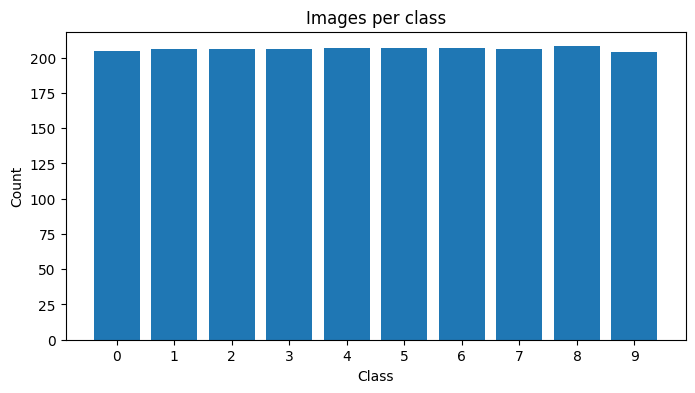

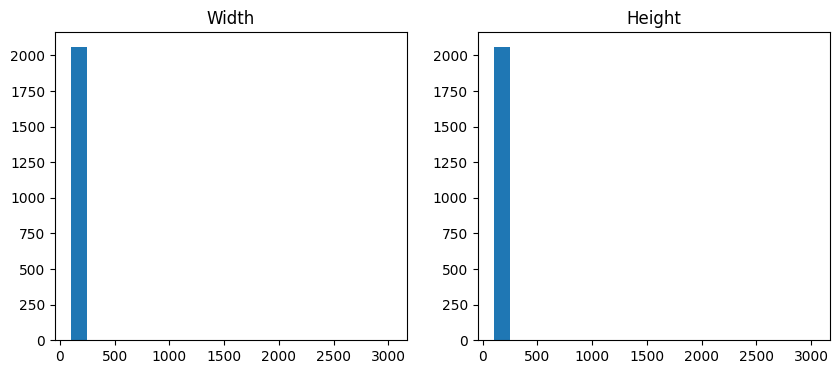

In [6]:
import matplotlib.pyplot as plt

# Per-class bar chart
counts = manifest.groupby("cls").size()
plt.figure(figsize=(8,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Images per class")
plt.xlabel("Class"); plt.ylabel("Count")
plt.show()

# Image size distribution
wh = []
for p in manifest.path:
    img = cv2.imread(p)
    if img is None: continue
    h,w = img.shape[:2]
    wh.append((w,h))
wh = np.array(wh)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.hist(wh[:,0], bins=20); plt.title("Width")
plt.subplot(1,2,2); plt.hist(wh[:,1], bins=20); plt.title("Height")
plt.show()


In [8]:
import mediapipe as mp

mp_hands = mp.solutions.hands.Hands(
    static_image_mode=True, 
    max_num_hands=1, 
    min_detection_confidence=0.5
)

In [9]:
import cv2
import matplotlib.pyplot as plt

def process_with_fallback(manifest, out_csv, out_miss_dir):
    rows = []
    misses = []

    for idx, row in manifest.iterrows():
        img_path = row['path']
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        res = mp_hands.process(rgb)

        if res.multi_hand_landmarks:
            lms = res.multi_hand_landmarks[0].landmark
            xs = [lm.x for lm in lms]; ys = [lm.y for lm in lms]
            x1, x2 = max(0.0, min(xs)), min(1.0, max(xs))
            y1, y2 = max(0.0, min(ys)), min(1.0, max(ys))
            rows.append([img_path, row['cls'], x1, y1, x2, y2])
        else:
            # Fallback = full frame
            rows.append([img_path, row['cls'], 0.0, 0.0, 1.0, 1.0])
            misses.append(img_path)

    pd.DataFrame(rows, columns=['path','cls','x1','y1','x2','y2']).to_csv(out_csv, index=False)

    print(f"Done. {len(rows)} processed, {len(misses)} fallback (misses).")
    return misses

misses = process_with_fallback(manifest, "bboxes_fixed.csv", "missed_samples")


C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Done. 2062 processed, 345 fallback (misses).


In [11]:
bboxes_df = pd.read_csv("bboxes_fixed.csv")

In [15]:
print(bboxes_df.columns)

Index(['path', 'cls', 'x1', 'y1', 'x2', 'y2'], dtype='object')


In [17]:
print(bboxes_df.head())
print(bboxes_df.columns)


                                                path  cls        x1        y1  \
0  C:\Users\sayu\Desktop\Sign_Language\RealTimeOb...    0  0.372634  0.209525   
1  C:\Users\sayu\Desktop\Sign_Language\RealTimeOb...    0  0.351383  0.187963   
2  C:\Users\sayu\Desktop\Sign_Language\RealTimeOb...    0  0.356831  0.237957   
3  C:\Users\sayu\Desktop\Sign_Language\RealTimeOb...    0  0.298923  0.170886   
4  C:\Users\sayu\Desktop\Sign_Language\RealTimeOb...    0  0.310077  0.111786   

         x2        y2  
0  0.602588  0.600878  
1  0.615668  0.688581  
2  0.585798  0.752573  
3  0.667561  0.802975  
4  0.726588  0.725268  
Index(['path', 'cls', 'x1', 'y1', 'x2', 'y2'], dtype='object')


In [18]:
print(bboxes_df['path'].iloc[:5])

0    C:\Users\sayu\Desktop\Sign_Language\RealTimeOb...
1    C:\Users\sayu\Desktop\Sign_Language\RealTimeOb...
2    C:\Users\sayu\Desktop\Sign_Language\RealTimeOb...
3    C:\Users\sayu\Desktop\Sign_Language\RealTimeOb...
4    C:\Users\sayu\Desktop\Sign_Language\RealTimeOb...
Name: path, dtype: object


In [19]:
import os
print(os.path.exists(bboxes_df['path'].iloc[0]))

True


In [20]:
saved = 0
for _, r in bboxes_df.iterrows():
    p, cls = r['path'], int(r['cls'])
    bgr = cv2.imread(p)
    if bgr is None:
        continue
    H, W = bgr.shape[:2]

    # use x1,y1,x2,y2 instead of x1n,y1n,...
    x1s, y1s, x2s, y2s = make_square_bbox_px(r['x1'], r['y1'], r['x2'], r['y2'], W, H, extra=0.20)
    crop = bgr[y1s:y2s, x1s:x2s]
    if crop.size == 0:
        continue

    rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    inp = letterbox_rgb(rgb, IMG_SIZE)

    out_dir = CROPS_DIR / str(cls)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / Path(p).name

    cv2.imwrite(str(out_path), cv2.cvtColor(inp, cv2.COLOR_RGB2BGR))
    saved += 1

print("Saved crops:", saved, "into", CROPS_DIR)


Saved crops: 2062 into C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\workspace\crops_128


In [21]:
# === Member 4: Normalization notes & quick checks ===
# We convert BGR->RGB above, then let the CNN apply Rescaling(1/255) internally.
# Small sanity: per-class average brightness of saved crops
stats = []
for cls in map(str, range(10)):
    for p in (CROPS_DIR/cls).glob("*"):
        bgr = cv2.imread(str(p))
        if bgr is None: continue
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        stats.append(dict(cls=int(cls), mean=float(gray.mean())))
pd.DataFrame(stats).groupby("cls").mean().round(1)


,mean
cls,
0,165.8
1,170.3
2,168.4
3,167.0
4,168.5
5,165.9
6,169.0
7,167.8
8,167.4


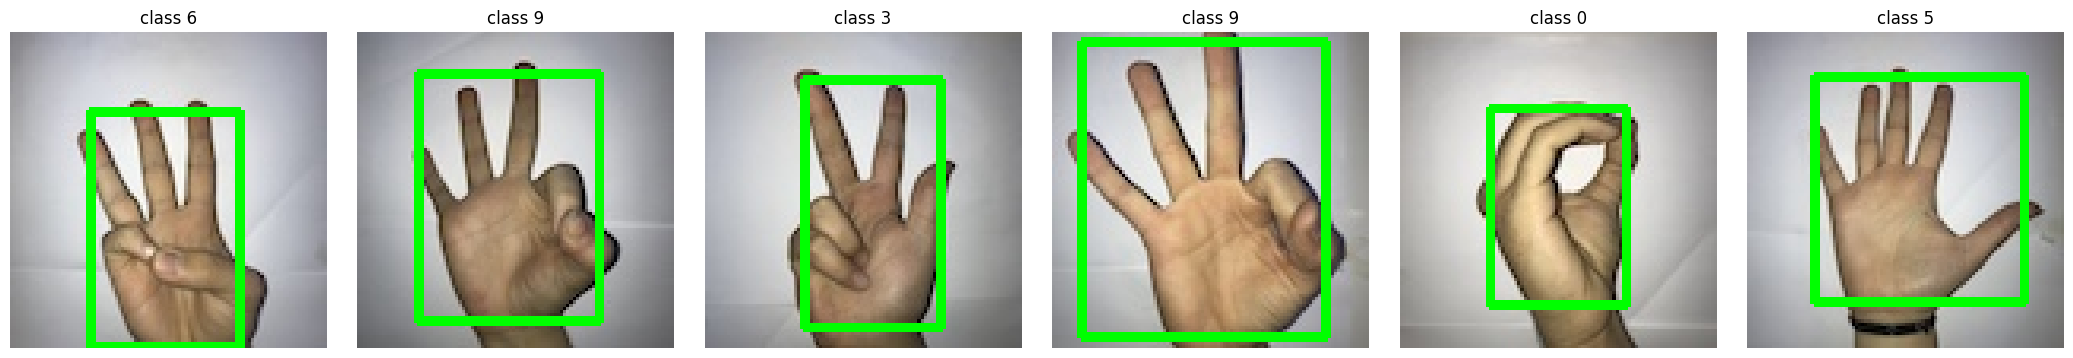

In [22]:
import cv2, matplotlib.pyplot as plt
import numpy as np
import pandas as pd

BBOX_CSV = WORK/"bboxes_all.csv"
df = pd.read_csv(BBOX_CSV)

def show_annotated(df, n=6):
    samp = df.sample(n, random_state=42)
    cols = min(n, 6); rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(3.5*cols, 3.5*rows))
    axes = np.atleast_1d(axes).ravel()

    for ax, (_, row) in zip(axes, samp.iterrows()):
        img = cv2.imread(row["path"])
        if img is None:
            ax.axis("off"); continue
        h, w = img.shape[:2]
        x1 = int(row["x1n"] * w); y1 = int(row["y1n"] * h)
        x2 = int(row["x2n"] * w); y2 = int(row["y2n"] * h)
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(f"class {int(row['cls'])}")
        ax.axis("off")

    # hide any extra axes
    for i in range(len(samp), len(axes)):
        axes[i].axis("off")
    plt.tight_layout(); plt.show()

show_annotated(df, n=6)


In [23]:
# === Member 5: Quality filtering + stratified splits ===
def blur_score(img_bgr):
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(g, cv2.CV_64F).var()

keep = []
for cls in map(str, range(10)):
    for p in (CROPS_DIR/cls).glob("*"):
        bgr = cv2.imread(str(p))
        if bgr is None: continue
        H,W = bgr.shape[:2]
        if min(H,W) < 64:      # tiny? (shouldn't happen with 128x128, but safe)
            continue
        if blur_score(bgr) < 45:   # too blurry? tune as needed
            continue
        keep.append(dict(path=str(p), cls=int(cls)))
clean_df = pd.DataFrame(keep)
print("Kept after QC:", len(clean_df))

from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(clean_df, test_size=0.30, stratify=clean_df.cls, random_state=RNG_SEED)
val_df,   test_df = train_test_split(temp_df,  test_size=0.50, stratify=temp_df.cls,  random_state=RNG_SEED)

for name, df in [("train",train_df),("val",val_df),("test",test_df)]:
    f = SPLITS/(name+".txt")
    df[["path","cls"]].to_csv(f, index=False, header=False)
    print(name, len(df), "->", f)


Kept after QC: 2061
train 1442 -> C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\workspace\splits\train.txt
val 309 -> C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\workspace\splits\val.txt
test 310 -> C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\workspace\splits\test.txt


In [16]:
print(train_df.cls.dtype)           # should be int
assert train_df.cls.min() == 0 and train_df.cls.max() == 9
loss = tf.keras.losses.SparseCategoricalCrossentropy()


int64


In [17]:
print("class distribution:", train_df.cls.value_counts().sort_index().to_dict())


class distribution: {0: 143, 1: 144, 2: 144, 3: 144, 4: 145, 5: 145, 6: 144, 7: 144, 8: 146, 9: 143}


(8, 128, 128, 3) <dtype: 'float32'> [7 8 2 3 7 9 9 8]


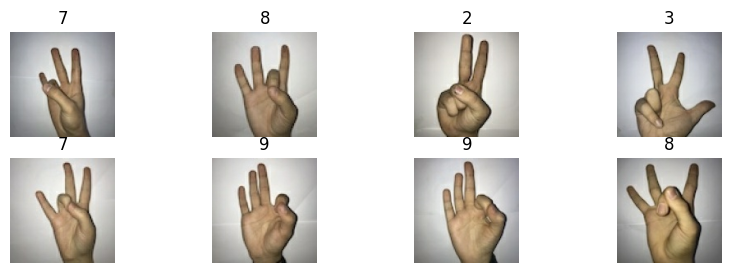

In [30]:
x_batch, y_batch = next(iter(train_ds.unbatch().batch(8)))
print(x_batch.shape, x_batch.dtype, y_batch.numpy())
plt.figure(figsize=(10,3))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i].numpy().astype("float32"))
    plt.title(int(y_batch[i]))
    plt.axis("off")
plt.show()


In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(input_shape=(128,128,3), num_classes=10):
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
##tiny = train_ds.take(1).repeat(30)  # take 1 batch, repeat it 30 times
##model = build_model()
##model.compile(optimizer='adam',
              ##loss='sparse_categorical_crossentropy',
              ##metrics=['accuracy'])
##model.fit(tiny, epochs=20)


In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

ckpt = ModelCheckpoint(
    "models/sign_digits_classifier.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)
early = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)
plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

model = build_model()  # your final architecture with augmentation+regularization enabled
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[ckpt, early, plateau]
)


Epoch 1/30
46/46 [==============================] - 41s 869ms/step - loss: 1.9877 - accuracy: 0.3044 - val_loss: 1.1353 - val_accuracy: 0.6731 - lr: 0.0010
Epoch 2/30
46/46 [==============================] - 39s 864ms/step - loss: 1.0000 - accuracy: 0.6540 - val_loss: 0.6940 - val_accuracy: 0.8026 - lr: 0.0010
Epoch 3/30
46/46 [==============================] - 39s 860ms/step - loss: 0.6996 - accuracy: 0.7691 - val_loss: 0.6214 - val_accuracy: 0.8123 - lr: 0.0010
Epoch 4/30
46/46 [==============================] - 39s 869ms/step - loss: 0.5817 - accuracy: 0.8100 - val_loss: 0.5373 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 5/30
46/46 [==============================] - 39s 862ms/step - loss: 0.4564 - accuracy: 0.8384 - val_loss: 0.4853 - val_accuracy: 0.8641 - lr: 0.0010
Epoch 6/30
46/46 [==============================] - 39s 869ms/step - loss: 0.3558 - accuracy: 0.8835 - val_loss: 0.4271 - val_accuracy: 0.8835 - lr: 0.0010
Epoch 7/30
46/46 [==============================] - 39s 856ms/st

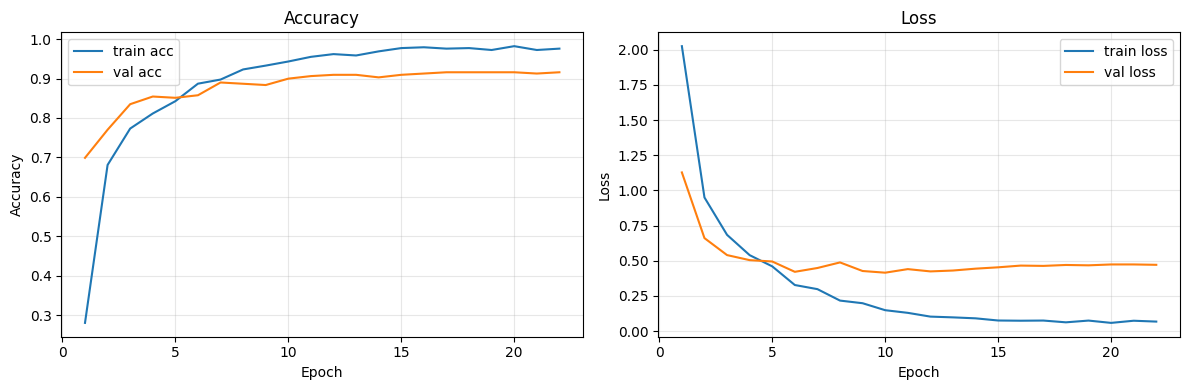

In [25]:
# === Visualize learning curves ===
import matplotlib.pyplot as plt

hist = history.history
epochs = range(1, len(hist["loss"]) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, hist["accuracy"], label="train acc")
plt.plot(epochs, hist.get("val_accuracy", []), label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(epochs, hist["loss"], label="train loss")
plt.plot(epochs, hist.get("val_loss", []), label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
# (Optional) save
# plt.savefig(WORK/"training_curves.png", dpi=150, bbox_inches="tight")


In [28]:
from tensorflow.keras.models import load_model

best_model = load_model("models/sign_digits_classifier.keras")
val_loss, val_acc = best_model.evaluate(val_ds)
print(f"Best model validation accuracy: {val_acc:.2%}")

10/10 [==============================] - 3s 205ms/step - loss: 0.4633 - accuracy: 0.9159
Best model validation accuracy: 91.59%
